In [212]:
from math import *
import matplotlib.pyplot as plt
import numpy as np

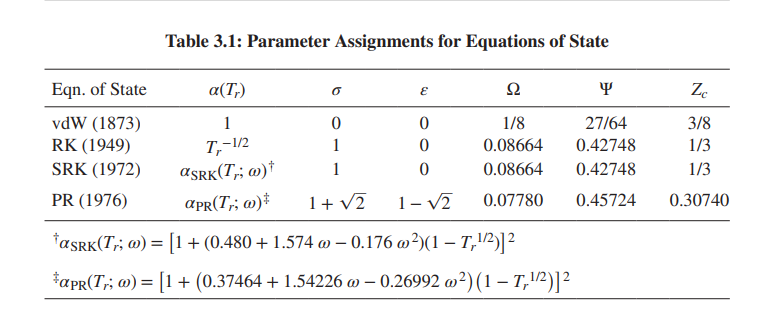

In [213]:
#def w_(pc , p_sat):
    
    #return -1-log10(p_sat/pc)

def thermo_model(model_name , T, Tc , p, pc, w_ ):

    if model_name == 'vdw':
        w = None
        alpha = 1
        sigma = 0
        epsilon = 0
        omega = 1/8
        epsay = 27/64
        Zc = 3/8
        return alpha , sigma , epsilon , omega , epsay , Zc ,w
    
    elif model_name == 'rk':
        w = None
        alpha = 1/sqrt(T/Tc)
        sigma = 1
        epsilon = 0
        omega = 0.08664
        epsay = 0.42748
        Zc = 1/3
        return alpha , sigma , epsilon , omega , epsay , Zc ,w

    elif model_name == 'srk':    
        w = w_
        #w = w_(pc , p_sat)
        alpha = (1 + (0.48 + 1.576*w - 0.176*(w**2) )*(1-sqrt(T/Tc)) )**2
        sigma = 1
        epsilon = 0
        omega = 0.08664
        epsay = 0.42748
        Zc = 1/3
        return alpha , sigma , epsilon , omega , epsay , Zc , w

    elif model_name == 'pr': 
        w = w_
        alpha = (1 + (0.37464 + 1.54226*w - 0.26992*(w**2) )*(1-sqrt(T/Tc)) )**2
        sigma = 1 + sqrt(2)
        epsilon = 1 - sqrt(2)
        omega = 0.07778
        epsay = 0.45724
        Zc = 0.3074
        return alpha , sigma , epsilon , omega , epsay , Zc , w

def beta_q(model_name ,T, Tc , p , pc  , w_ ):
    alpha , sigma , epsilon , omega , epsay , Zc , w = thermo_model(model_name ,T, Tc , p , pc  , w_)

    beta = omega*(p/pc)/(T/Tc)
    q    = epsay*alpha /(omega * (T/Tc))

    return beta , q

def Z_vap(model_name , T , Tc , p , pc  , w_ ):

    alpha , sigma , epsilon , omega , epsay , Zc , w = thermo_model(model_name ,T, Tc , p , pc  , w_)

    beta , q = beta_q(model_name ,T, Tc , p , pc  , w_ )
    z = 0.5
    error_ = []
    for i in range(50):
        
        z_calc = 1 + beta - (q*beta*(z-beta))/((z+epsilon*beta)*(z+sigma*beta))
        error = abs(z-z_calc)
        error_.append(error)
        z_vap = z_calc
        
        if error < 0.0001:
            return z_vap , error , error_
            break
        else:
            z = z_calc

    return z_vap , error , error_           

def Z_liq(model_name , T , Tc , p , pc  , w_ ):

    alpha , sigma , epsilon , omega , epsay , Zc , w = thermo_model(model_name ,T, Tc , p , pc  , w_)

    beta , q = beta_q(model_name ,T, Tc , p , pc  , w_ )
    z = beta
    error_ = []

    for i in range(10):
        
        z_calc = beta + (z+epsilon*beta)*(z + sigma*beta)*((1+beta-z)/(q*beta))
        error = abs(z-z_calc)
        error_.append(error)
        z_liq = z_calc
        
        if error < 0.001:
            return z_liq , error , error_
            break
        else:
            z = z_calc            


    return z_liq , error , error_    

def H_residual(model_name , T , Tc , p ,pc  , Z_vap  , beta_q  , w_): #RK / Vdw version
    alpha , sigma , epsilon , omega , epsay , Zc ,w = thermo_model(model_name ,T, Tc , p , pc  , w_)
    beta , q = beta_q(model_name ,T, Tc , p , pc  , w_ )
    z_vap , error , error_ = Z_vap(model_name , T , Tc , p , pc  , w_)
    pr = p/pc
    tr = T/Tc
    if model_name == 'rk':
        I = ( 1 / (sigma-epsilon) ) * log( (z_vap+sigma*beta) / (z_vap+epsilon*beta) )
    #d_alpha_dt = d_alpha_dtr(model_name , T , Tc)
        H_res_RT = (z_vap - 1) + (( -0.5 -1  )*q*I)
        H_res = H_res_RT * 8.314 * T
        dq_dtr = None

    elif model_name == 'vdw':
        I = beta/z_vap
        H_res_RT = z_vap - 1 + tr * I * epsay * -1 /(omega * tr**2)
        H_res = H_res_RT * 8.314 * T
        dq_dtr = None
    
    elif model_name == 'pr':
        #z_vap = 0.6907
        w = w_
        I = ( 1 / (sigma-epsilon) ) * log( (z_vap+sigma*beta) / (z_vap+epsilon*beta) )
        y = 0.37464+1.54226*w -0.26992*w**2
        dq_dtr = (epsay/omega) *( tr**(-1.5) * (-y-y**2) + ((y**2)/tr) - ((1+y*(1-tr**0.5))**2)/tr**2)
        H_res_RT = (z_vap - 1) + tr*dq_dtr*I
        H_res = H_res_RT * 8.314 * T
        
    return H_res , z_vap , q , I , tr , alpha  , H_res_RT , error_ , dq_dtr



            

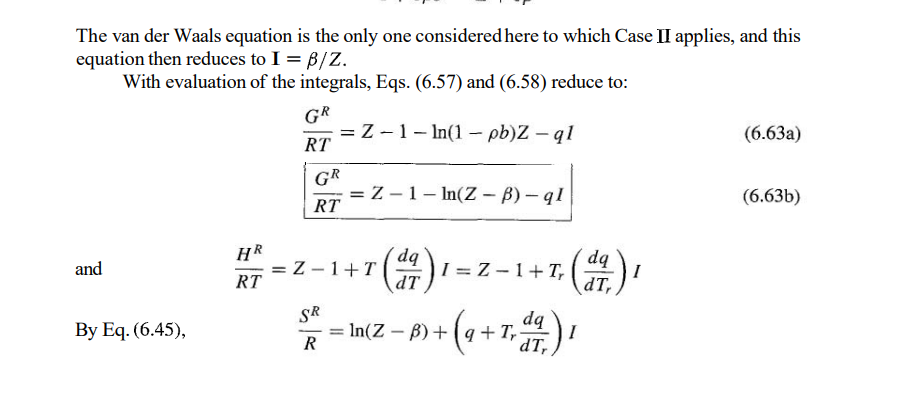

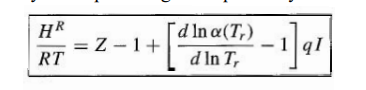

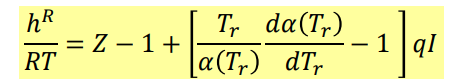

In [214]:
h_res_ , z_vap , q , I , tr , alpha  , H_res_RT , error_ , dq_dtr   = H_residual('pr' , 500 , 425.1 , 50 , 37.96  , Z_vap , beta_q  , 0.2)
h_res_ , z_vap , q , I , tr , alpha  , H_res_RT , error_ , dq_dtr

(-4986.105232128511,
 0.6907704911005137,
 4.446122552735782,
 0.1129260797802043,
 1.1761938367442955,
 0.8895780360411814,
 -1.1994479750128724,
 [0.10183733121168381,
  0.05141007089572902,
  0.022460260449033043,
  0.009160093919066248,
  0.00362881313333685,
  0.0014208840536420464,
  0.0005538040638466413,
  0.0002154635277680228,
  8.376984640801055e-05],
 -6.702293583224852)

In [215]:
H_res_ , z_vap , q , I , tr , alpha  , H_res_RT , error_ , dq_dtr = H_residual('vdw' , 500 , 425.1 , 50 , 37.96  , Z_vap , beta_q  , 0.2)
H_res_ , z_vap , q , I , tr , alpha  , H_res_RT , error_ , dq_dtr

(-3935.774219454432,
 0.6609418582624194,
 2.869425,
 0.21179302681832896,
 1.1761938367442955,
 1,
 -0.9467823477157643,
 [0.06155003798862957,
  0.04145094335364652,
  0.025498279135681923,
  0.014731891600620273,
  0.008191677982259282,
  0.004456244198094206,
  0.00239501501882744,
  0.0012787906142204264,
  0.0006803986822658814,
  0.0003613375504594174,
  0.00019170335505969138,
  0.00010165212330692786,
  5.388665934780157e-05],
 None)

In [216]:
H_res , z_vap , q , I , tr , alpha  , H_res_RT , error_ , dq_dtr = H_residual('rk' , 500 , 425.1 , 50 , 37.96  , Z_vap , beta_q  , 0.2)
H_res , z_vap , q , I , tr , alpha  , H_res_RT , error_ , dq_dtr

(-4503.231205369491,
 0.685134670484152,
 3.867933582317356,
 0.1324433961524237,
 1.1761938367442955,
 0.9220629045786409,
 -1.0832887191170295,
 [0.09040991459391434,
  0.05040680843728729,
  0.02459175260835922,
  0.01116718574449238,
  0.004901797448140233,
  0.0021192235615857813,
  0.0009101780666688208,
  0.0003897968618689074,
  0.00016673221035590213,
  7.128095147912461e-05],
 None)

for vap

In [217]:
z_vap , error,error_ = Z_vap('vdw' , 350 , 425.1 , 9.4573 , 37.96 , 37.96)
z_vap , error


(0.8667374874473751, 2.6370671440512083e-05)

Text(0, 0.5, 'error')

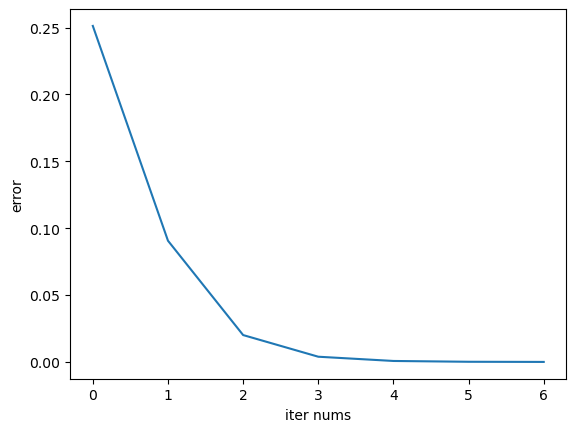

In [218]:
plt.plot(error_)
plt.xlabel("iter nums")
plt.ylabel("error")

In [219]:
z_vap , error,error_ = Z_vap('rk' , 350 , 425.1 , 9.4573 , 37.96 , 37.96)
z_vap , error
#plt.plot(error_)
#plt.xlabel("iter nums")
#plt.ylabel("error")

(0.830473536995858, 5.698458430369868e-05)

Text(0, 0.5, 'error')

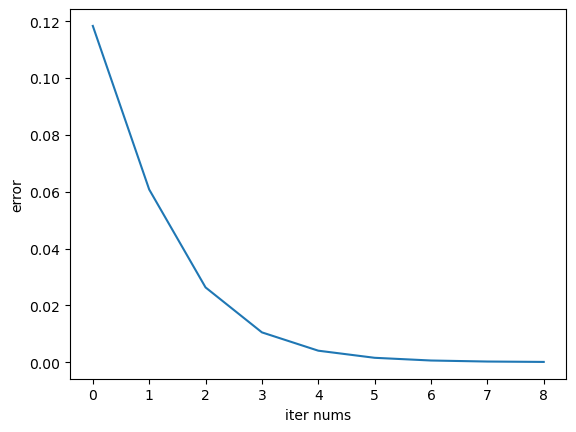

In [220]:
z_vap , error,error_ = Z_vap('srk' , 500 , 425.1 , 50 , 37.96 , 0.2)
z_vap , error
plt.plot(error_)
plt.xlabel("iter nums")
plt.ylabel("error")

Text(0, 0.5, 'error')

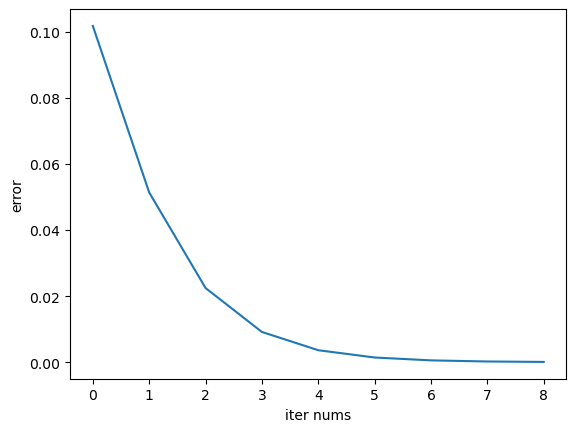

In [221]:
z_vap , error,error_ = Z_vap('pr' , 500 , 425.1 , 50 , 37.96 , 0.2)
z_vap , error
plt.plot(error_)
plt.xlabel("iter nums")
plt.ylabel("error")

for liq

In [222]:
z_liq , error , error_ = Z_liq('vdw' , 350 , 425.1 , 9.4573 , 37.96 , 37.96)
z_liq , error
#plt.plot(error_)
#plt.xlabel("iter nums")
#plt.ylabel("error")

(0.059351495267320475, 0.0009753214790428205)

In [223]:
z_liq , error , error_  = Z_liq('rk' , 350 , 425.1 , 9.4573 , 37.96 , 37.96)
z_liq , error , error_


(0.042138645461445294,
 0.0007391508682035169,
 [0.007939268941571556,
  0.003875849984802837,
  0.0021305931645590748,
  0.0012368143668875647,
  0.0007391508682035169])

In [224]:
z_liq , error , error_  = Z_liq('srk' , 350 , 425.1 , 9.4573 , 37.96 , 37.96)
z_liq , error ,error_



(0.026247588189780874, 3.0620054360129545e-05, [3.0620054360129545e-05])

In [226]:
z_liq , error,error_  = Z_liq('pr' , 350 , 425.1 , 9.4573 , 37.96 , 37.96)
z_liq , error , error_


(0.023543503484328796, 7.5410931350550214e-06, [7.5410931350550214e-06])

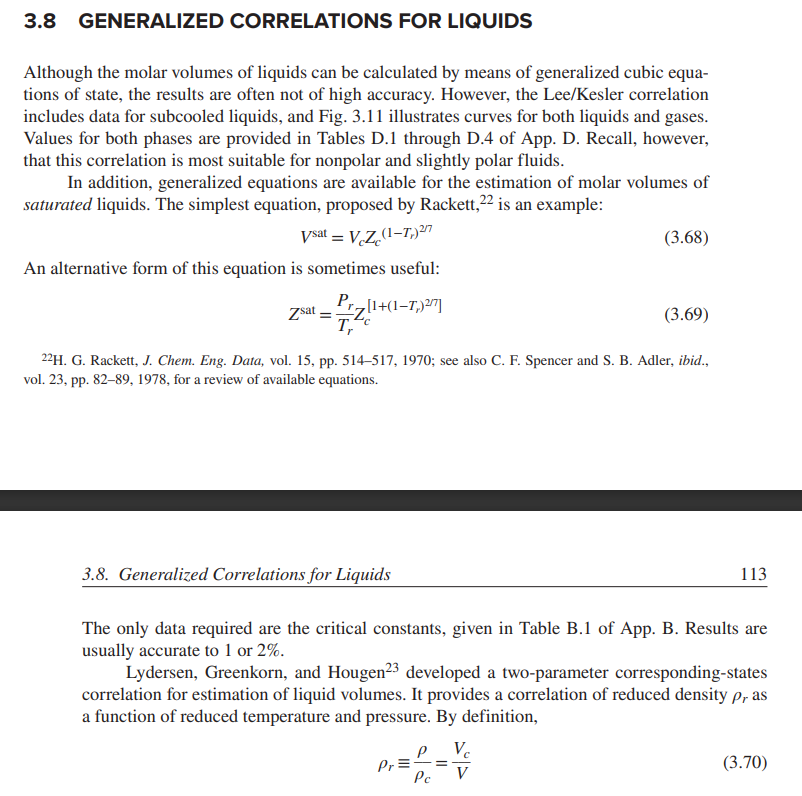

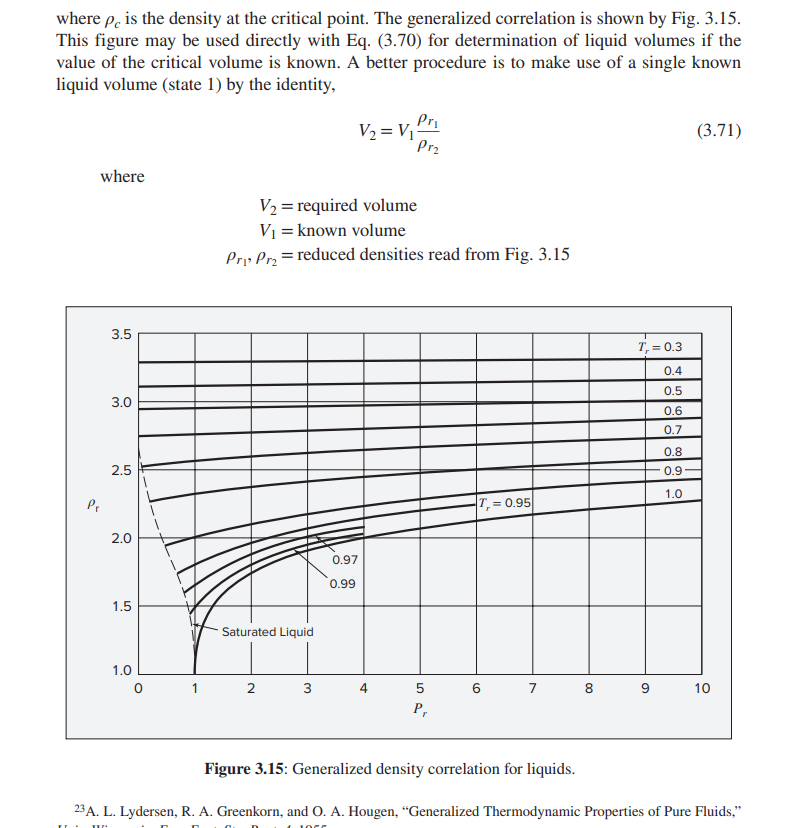